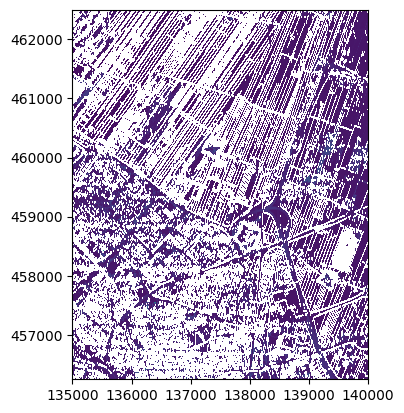

<AxesSubplot:>

In [88]:
# !brew install gdal
# !pip install rasterio

import rasterio
from rasterio.plot import show

fp = r'R_31HN2.TIF'
img = rasterio.open(fp)
show(img)

In [89]:
# print(img.width, img.height, img.indexes)
img_data = img.read(1)
img_height = img_data.shape[0]
img_width = img_data.shape[1]


In [90]:
import math


def get_point_on_line(angle_deg, length, start_x, start_y):
    angle_deg = angle_deg % 360
    theta = angle_deg * math.pi / 180.0

    line_end_x = start_x + length * math.cos(theta)
    line_end_y = start_y + length * math.sin(theta)

    return line_end_x, line_end_y

In [91]:
from tqdm import tqdm

min_height = 99999
max_height = -99999
for y in tqdm(range(0, img_height)):
    for x in range(0, img_width):
        depth = img_data[y, x]
        if depth < min_height:
            min_height = depth

        if depth > max_height:
            max_height = depth

print(min_height, max_height)

100%|██████████| 12500/12500 [00:22<00:00, 544.27it/s]

-3.871 3.4028235e+38


In [100]:
def get_ray_length(center_x, center_y, angle_deg):
    ray_starting_depth = None
    for ray_length in np.arange(0, max_ray_length, ray_step_size):
        ray_coords = get_point_on_line(angle_deg, ray_length, start_x=center_x, start_y=center_y)
        ray_coords = (int(ray_coords[0]), int(ray_coords[1]))

        ray_exceeds_bounds = ray_coords[0] < 0 or ray_coords[1] < 0 or ray_coords[1] >= img_height or ray_coords[
            0] >= img_width
        if ray_exceeds_bounds:
            break

        depth = img_data[ray_coords[1], ray_coords[0]]
        if ray_starting_depth is None:
            ray_starting_depth = depth

        ray_is_obstructed = ray_starting_depth - depth > MAX_HEIGHT_DIFF_VIEWER_OBSTRUCTION
        if ray_is_obstructed:
            ray_length_before_obstructed = ray_length

            # ray_info = f"Ray at angle {angle_deg}, length before obstructed: {ray_length_before_obstructed}. Viewer ({center_x}, {center_y}) height: {ray_starting_depth}, obstruction ({ray_coords}) depth: {depth}"
            return ray_length_before_obstructed, angle_deg

In [ ]:
from operator import itemgetter
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

angle_step_size = 0.1
ray_step_size = 1
max_ray_length = 99999999

center_x = int(img_width / 2)
center_y = int(img_height / 2)

MAX_HEIGHT_DIFF_VIEWER_OBSTRUCTION = 0.5

azimuth_sunset_deg = 217
sunset_min_angle_deg = azimuth_sunset_deg - 5
sunset_max_angle_deg = azimuth_sunset_deg + 5

results = Parallel(n_jobs=10)(delayed(get_ray_length)(center_x, center_y, angle_deg) for angle_deg in
                             np.arange(sunset_min_angle_deg, sunset_max_angle_deg, angle_step_size))

best_ray = max(results,key=itemgetter(0))
print(f"Angle: {best_ray[1]}, length: {best_ray[0]}")

# for angle_deg in np.arange(sunset_min_angle_deg, sunset_max_angle_deg, angle_step_size):
#     ray_length, ray_info = get_ray_length(center_x, center_y, angle_deg)
#     print(f"Angle: {angle_deg}, length: {ray_length}")

# Min height: -3.794
# Max height: 3.4028235e+38
